Developing models for Classification based on demographic labels

In this notebook I will train various models using supervised learning and evaluate their performance.

Model Interpretability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,6)
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
demo_list = list(pd.read_csv('data/hh_demographic.csv')['household_key'])


In [26]:
weekly_hh = pd.read_csv('data/outputs/hh_tensors.csv')
weekly_hh['household_key'] = weekly_hh['household_key'].astype(int)
weekly_hh = weekly_hh.set_index('household_key')
# 2485 households

In [60]:
demo = pd.read_csv('data/hh_demographic.csv')
demo.head()
# 801 households

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [61]:
df = weekly_hh.merge(demo, on='household_key').set_index('household_key') # household_key
df.shape

(801, 27)

In [62]:
df.columns

Index(['weekly_sum_sales', 'weekly_retail_disc', 'weekly_num_baskets',
       'weekly_item_quantity', 'weekly_unique_products', 'weekly_alcohol',
       'weekly_beverages', 'weekly_concessions', 'weekly_dairy', 'weekly_drug',
       'weekly_garden', 'weekly_grain_goods', 'weekly_grocery',
       'weekly_home_family', 'weekly_junk_food', 'weekly_kitchen',
       'weekly_meat', 'weekly_misc', 'weekly_produce', 'weekly_seasonal',
       'AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC',
       'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'],
      dtype='object')

<AxesSubplot:>

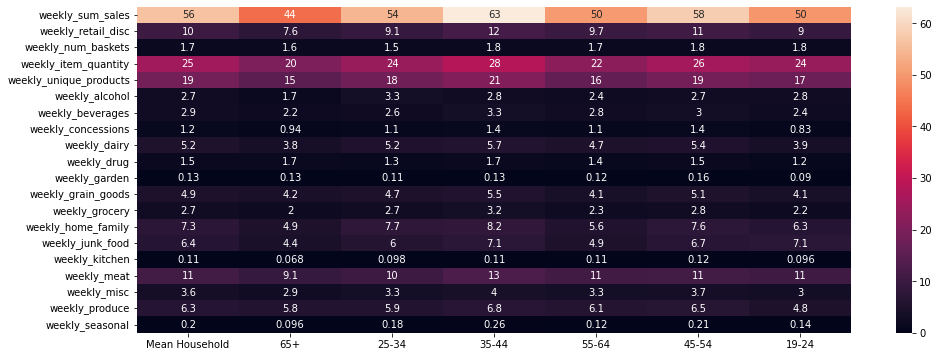

In [63]:
def compare_group_to_mean(df, label_col):
    output = pd.DataFrame()
    WEEKLY_MEAN = df.drop(['MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC',
       'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'], axis=1).mean()
    WEEKLY_MEAN.name = 'Mean Household'
    output = output.append(WEEKLY_MEAN)
    
    for group in df[label_col].unique():
        labeled_subsection = df[df[label_col]==group]
        x = labeled_subsection.drop(['MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC',
           'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC'], axis=1).mean()
        x.name = group
        output = output.append(x)
        
    return output

sns.heatmap(compare_group_to_mean(df, 'AGE_DESC').T, vmin=0, annot=True)
    

# Defining `X` and `y`


For this part of the analysis, we'd like to get a better idea of what distinguishes 

In [243]:
### Drop weekly_sum_sales because of multi-collinearity
X = df.drop(['age_45+',
             'income_50K+',
             'single_couple_family', 
             'single', 'couple', 'has_kids',
             'household_key',
            ], axis=1)
y = df['single']

# Train Test Split

In [244]:
y_train.name

'single'

In [245]:
def fast_split_scale(target_column, df=df, test_size=0.15):
    '''pass the column name from target_df `y` as a string to perform a fast train_test split'''
    
    X = df.drop(['age_45+',
             'income_50K+',
             'single_couple_family', 
             'single', 'couple', 'has_kids',
             'household_key',
            ], axis=1)
    
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    ss = MinMaxScaler().fit(X_train)
    X_train = ss.transform(X_train)
    X_test = ss.transform(X_test)
    return X_train, X_test, y_train, y_test

In [246]:
X_train, X_test, y_train, y_test = fast_split_scale('couple')

In [247]:
y_train.name

'couple'

# PCA

What can PCA tell us about the importance of our columns, with respect to condensing the information? That is to say, which features are most tangibly distinctive, and create the longest distance between points along an axis; thereby reducing the information lost by dropping the feature columns? We add in the less important columns in between 'ticks' along the PCA; the explained variance ratio shows us which columns are contributing to the act of anchoring the data cloud in a real feature space.

This is something of a reverse SVM, where instead of defining the boundaries between classes, we are condensing the entire data cloud and putting it within boundaries. The axis through the feature space which retains the highest variance while reducing the number of data points (down to one or more PCA columns).

This isn't a great time to use PCA because we have most aggregate sales information with intercorrelated points. We're not seeking to represent all this information as a condensed vector; instead, we're trying to create decision boundaries within the feature space we've tried so hard to create.

In [248]:
mypca = PCA()
mypca.fit(X_train)

print(target, '\n', pd.DataFrame((np.round(mypca.explained_variance_ratio_,4) * 100), index=X.columns, columns=['Impact on PCA']).head())   
print()

income_50K+ 
                 Impact on PCA
total_spend             49.09
total_loyalty            9.50
total_coupon             6.14
total_quantity           3.97
num_baskets              3.19



# Logistic Regression


In [249]:
X_train, X_test, y_train, y_test = fast_split_scale('age_45+')

In [250]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()

In [251]:
logit.fit(X_train, y_train)

LogisticRegression()

In [252]:
cross_val_score(logit, X_train, y_train).mean()

0.5235294117647058

In [253]:
cross_val_score(logit, X_test, y_test).mean()

0.496

Text(0.5, 1.0, 'logistic regression train vs test accuracy')

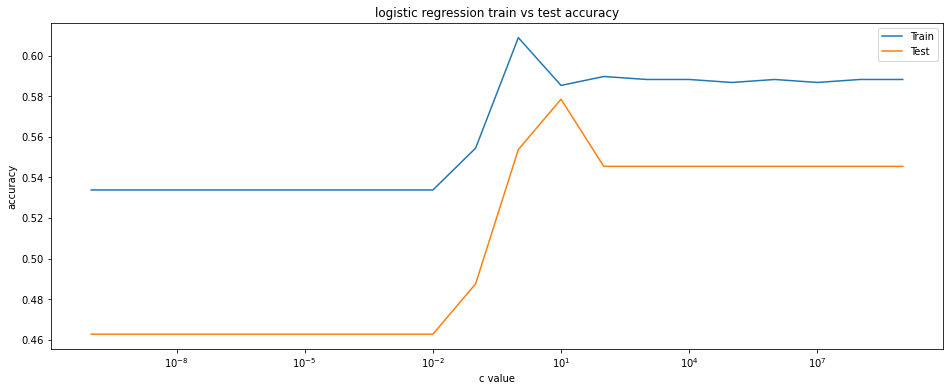

In [254]:
# Logisitic Regression

c_values = 10**np.arange(-10.0,10.0)
train_scores = []
test_scores = []

for c in c_values:
    log_model = LogisticRegression(C=c)
    log_model.fit(X_train, y_train)
    train_scores.append(log_model.score(X_train, y_train))
    test_scores.append(log_model.score(X_test, y_test))
    
plt.figure()
plt.plot(c_values,train_scores,label = "Train")
plt.plot(c_values,test_scores,label = "Test")
plt.legend()
plt.xscale('log')
plt.xlabel('c value')
plt.ylabel('accuracy')
plt.title('logistic regression train vs test accuracy')

# Decision Tree

Decision Trees are one of the core models a data scientist might use for classification tasks. With given labels (supervised learning), we can draw decision boundaries between data points in a given feature space. 

If left unchecked, a decision tree will always create a perfect boundary rules between points and attain 100% accuracy (unless two identical points are identically labeled). 

Since the separation happens on a feature-by-feature or column level basis, scaling does little to improve performance; but since the boundaries are straightforward (and also therefore relatively and easy to interpret), they're already very fast models. 

In [193]:
DT = DecisionTreeClassifier(min_samples_leaf=50, min_impurity_split=0.4)

By setting the `min_samples_leaf` and `min_impurity_split` parameters, we can ensure our divisions are clean and offer a general outlook. Hopefully this will make them more robust, and less prone to overfitting.

In [194]:
DT.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_split=0.4, min_samples_leaf=50)

In [195]:
pd.Series(index = X.columns, data=DT.feature_importances_).sort_values(ascending=False)[:5]

beverages          0.158830
home_family        0.134088
unique_products    0.126841
drug               0.114766
grain_goods        0.109230
dtype: float64

In [196]:
accuracy_score(y_test, DT.predict(X_test))

0.5785123966942148

In [197]:
cross_val_score(DT, X_test, y_test).mean()

0.5536666666666666

Really not bad. 

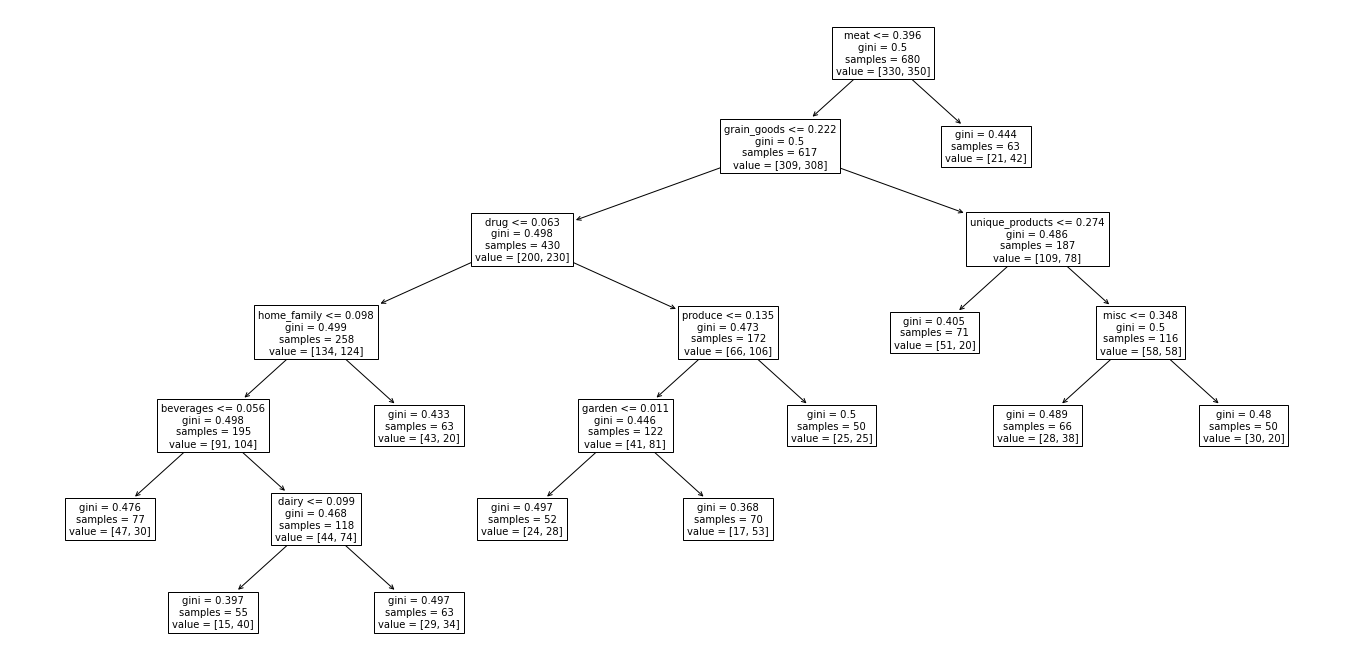

In [198]:
from sklearn.tree import plot_tree

plt.figure(figsize=(24,12))
plot_tree(DT,fontsize=10, feature_names=X.columns)
plt.show()

We see that our model can distinguish between our labeled targets or not based on the criteria above. It's quite interesting -- and informative -- to take a look at how this model divides the households up for various labels. 

In [229]:
def DT_model(df, 
             target='single',
             plot_tree=False):
    
    ### Drop weekly_sum_sales because of multi-collinearity
    X = df.drop([
                 'age_45+',
                 'income_50K+',
                 'single_couple_family', 
                 'single', 'couple', 'has_kids',
                 'household_key',
                ], axis=1)
    y = df[target]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    
    DT = DecisionTreeClassifier(min_samples_leaf=50, min_impurity_split=0.4)
    DT.fit(X_train, y_train)
    
    ft_importances = pd.Series(index = X_train.columns, data=DT.feature_importances_).sort_values(ascending=False)
    print(f'Predicting "{target}"')
    print('score', cross_val_score(DT, X_test, y_test).mean())
    
    if plot_tree==True:
        plt.figure(figsize=(24,12))
        plot_tree(DT,fontsize=10, feature_names=X_train.columns)
        plt.show()
    print('Feature Importances')
    return ft_importances

for target in targets:
    a = DT_model(df, target=target)
    print(a.head(3))
    print()

Predicting "single"
score 0.595
Feature Importances
home_family    0.289612
num_baskets    0.241466
dairy          0.162246
dtype: float64

Predicting "couple"
score 0.7026666666666668
Feature Importances
avg_item_cost    0.296516
alcohol          0.226929
garden           0.205315
dtype: float64

Predicting "has_kids"
score 0.6446666666666666
Feature Importances
total_loyalty    0.72497
total_coupon     0.27503
total_spend      0.00000
dtype: float64

Predicting "age_45+"
score 0.5453333333333332
Feature Importances
home_family        0.177664
unique_products    0.148494
garden             0.120841
dtype: float64

Predicting "income_50K+"
score 0.5373333333333332
Feature Importances
avg_item_cost       0.464586
avg_basket_spend    0.191301
dairy               0.142583
dtype: float64



Above we can see some of the 'feature importances' for various categories. Again we see the value in these decision tree models, in terms of their interpretability. Each target variable is drawing increased feature importance from categories which we might expect; such as alcohol for `couple`s, avg_item_cost for `income_50K+`, home_family goods for `age_45+`

# SVM

In [235]:
from sklearn.svm import SVC # non-linear separation 

Text(0.5, 1.0, 'support vector machines train vs test accuracy')

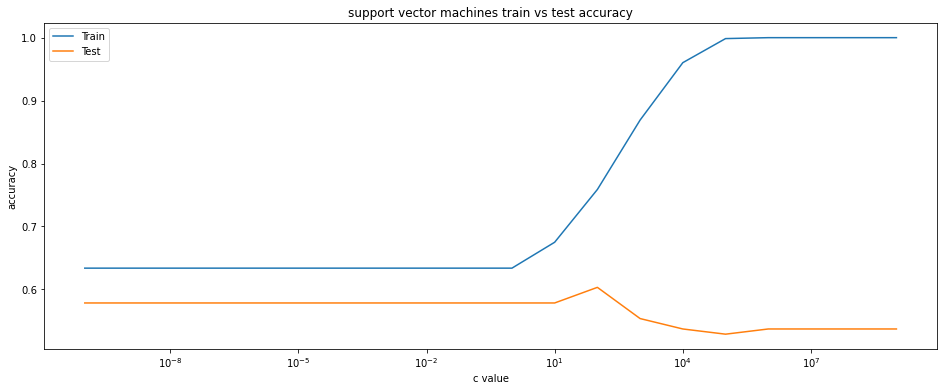

In [236]:
# SVC
c_values = 10**np.arange(-10.0,10.0)
train_scores = []
test_scores = []

for c in c_values:
    svm_model = SVC(C=c)
    svm_model.fit(X_train,y_train)
    train_scores.append(svm_model.score(X_train,y_train))
    test_scores.append(svm_model.score(X_test,y_test))
    
plt.figure()
plt.plot(c_values,train_scores,label = "Train")
plt.plot(c_values,test_scores,label = "Test")
plt.legend()
plt.xscale('log')
plt.xlabel('c value')
plt.ylabel('accuracy')
plt.title('support vector machines train vs test accuracy')

# Random Forest Classifier

In [237]:
from sklearn.ensemble import RandomForestClassifier

results = []
for max_depth in range(2,15):
    model = RandomForestClassifier(max_depth=max_depth)

    model.fit(X_train, y_train)

    results.append((max_depth, cross_val_score(model, X_test, y_test).mean()))
    

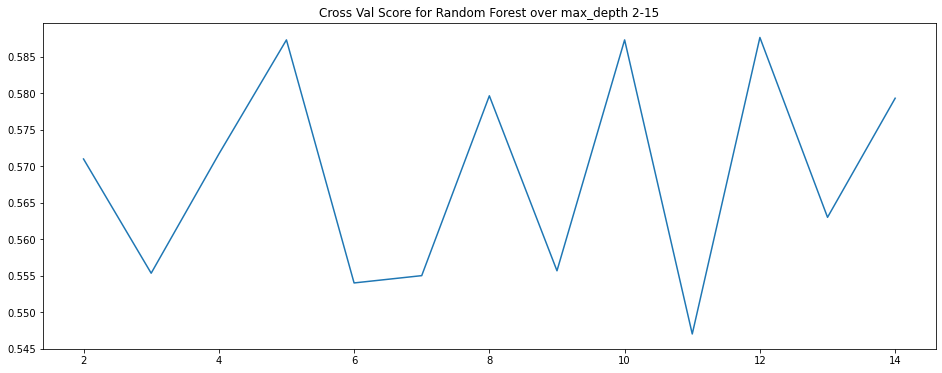

In [238]:
plt.plot(range(2,15), [x[1] for x in results])
plt.title('Cross Val Score for Random Forest over max_depth 2-15');


# XGBoost

XGBoost is a random forest model which implements a momentum-based gradient optimizer -- the branches learn which ways to grow. 

In [262]:
def test_xgb():
    accuracies =[]
    cross_vals = []
    train_scores = []
    for i in range(1,10):
        model = xgb.XGBClassifier(max_depth=i, learning_rate = 0.001, objective='reg:logistic')
        model.fit(X_train, y_train)
        results = model.predict(X_train)
        train_scores.append(accuracy_score(y_train, results))

        
        results = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, results))
        cross_vals.append(cross_val_score(model, X_test, y_test, scoring='accuracy', cv=6).mean())
        
        
    return train_scores, accuracies, cross_vals

In [ ]:
train_scores, accuracies, cross_vals = test_xgb()

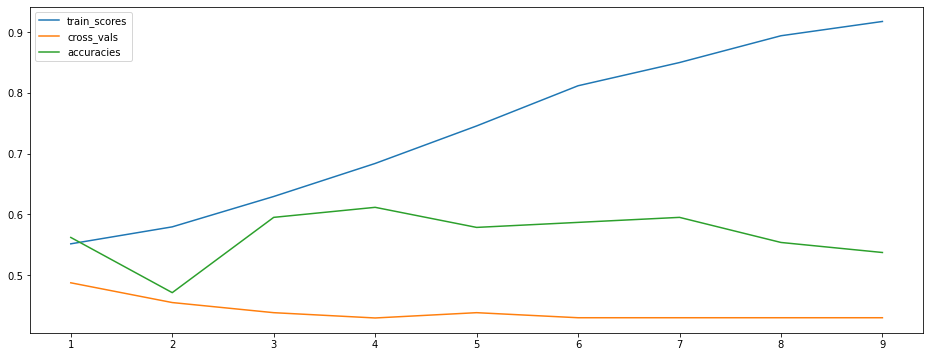

In [264]:
plt.plot(list(range(1,10)), train_scores, label='train_scores')
plt.plot(list(range(1,10)), cross_vals, label='cross_vals')
plt.plot(list(range(1,10)), accuracies, label='accuracies')
plt.legend()

In [265]:
def test_xgb():
    accuracies =[]
    cross_vals = []
    train_scores = []
    etas = [0.0001,0.001,0.01,0.1,0.3, 0.5,0.7,1,2,10,100, 250, 750]
    for i in etas:
        model = xgb.XGBClassifier(max_depth=2, learning_rate=i, objective='reg:logistic')
        model.fit(X_train, y_train)
        results = model.predict(X_train)
        train_scores.append(accuracy_score(y_train, results))

        
        results = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, results))
        cross_vals.append(cross_val_score(model, X_test, y_test, scoring='accuracy', cv=6).mean())
        
        
    return train_scores, accuracies, cross_vals

In [268]:
train_scores, accuracies, cross_vals = test_xgb()

In [269]:
etas = [0.0001,0.001,0.01,0.1,0.3, 0.5,0.7,1,2,10,100, 250, 750]

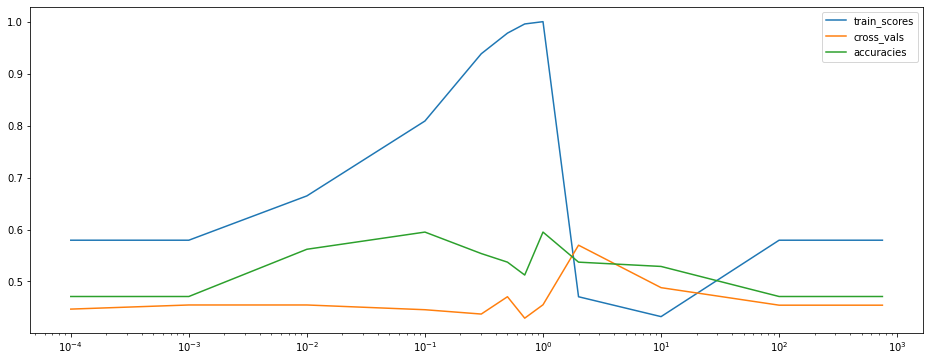

In [272]:
plt.plot(etas, train_scores, label='train_scores')
plt.plot(etas, cross_vals, label='cross_vals')
plt.plot(etas, accuracies, label='accuracies')
plt.xscale('log')
plt.legend()

In [273]:
model = xgb.XGBClassifier(max_depth=5, objective='reg:logistic')
model.fit(X_train, y_train)
accuracy_score(y_train, model.predict(X_train))

1.0

Great train score...

In [274]:
cross_val_score(model, X_test, y_test).mean()

0.4453333333333334

Not a great test score. Still, around the same score as for the DT model.